In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# 데이터 확인 

# train 데이터 
X_data = np.loadtxt('train_features.csv',skiprows=1,delimiter=',')
X_data = X_data[:,1:]
print(X_data.shape)
     
Y_data = np.loadtxt('train_target.csv',skiprows=1,delimiter=',')
Y_data = Y_data[:,1:]
print(Y_data.shape)

X_data = X_data.reshape((2800,375,5,1))
print(X_data.shape)

# test 데이터 
X_data_test = np.loadtxt('test_features.csv',skiprows=1,delimiter=',')
X_data_test = X_data_test[:,1:]
X_data_test = X_data_test.reshape((700,375,5,1))

(1050000, 5)
(2800, 4)
(2800, 375, 5, 1)


In [5]:
# 데이터 split
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)
print(X_train.shape)

(2240, 375, 5, 1)


In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten,MaxPooling2D,BatchNormalization,Lambda, AveragePooling2D
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import pandas as pd

Using TensorFlow backend.


In [6]:
# loss정의 
weight1 = np.array([1,1,0,0])
weight2 = np.array([0,0,1,1])

def my_loss(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult))


def my_loss_E1(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred)*weight1)/2e+04

def my_loss_E2(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult)*weight2)

In [7]:
# tr_target = 2 

def set_model(train_target):  # 0:x,y, 1:m, 2:v
    
    activation = 'elu'
    padding = 'valid'
    model = Sequential()
    nf = 16
    fs = (3,1)

    model.add(Conv2D(nf,fs, padding=padding, activation=activation,input_shape=(375,5,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*2,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*4,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*8,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*16,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*32,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Flatten())
    model.add(Dense(128, activation ='elu'))
    model.add(Dense(64, activation ='elu'))
    model.add(Dense(32, activation ='elu'))
    model.add(Dense(16, activation ='elu'))
    model.add(Dense(4))

    optimizer = keras.optimizers.Adam()

    global weight2
    if train_target == 1: # only for M
        weight2 = np.array([0,0,1,0])
    else: # only for V
        weight2 = np.array([0,0,0,1])
       
    if train_target==0:
        model.compile(loss=my_loss_E1,
                  optimizer=optimizer,
                 )
    else:
        model.compile(loss=my_loss_E2,
                  optimizer=optimizer,
                 )
       
    model.summary()

    return model

In [8]:
def train(model,X,Y):
    MODEL_SAVE_FOLDER_PATH = './model/'
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

    model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
    best_save = ModelCheckpoint('best_m.hdf5', save_best_only=True, monitor='val_loss', mode='min')


    history = model.fit(X, Y,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_split=0.2,
                  verbose = 2,
                  callbacks=[best_save])

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    plt.show()    
    
    return model

In [20]:
def plot_error(type_id,pred,true):
    print(pred.shape)

    if type_id == 0:
        _name = 'x_pos'
    elif type_id == 1:
        _name = 'y_pos'
    elif type_id == 2:
        _name = 'mass'
    elif type_id == 3:
        _name = 'velocity'
    elif type_id == 4:
        _name = "distance"
    else:
        _name = 'error'

    x_coord = np.arange(1,pred.shape[0]+1,1)
    if type_id < 2:
        Err_m = (pred[:,type_id] - true[:,type_id])
    elif type_id < 4:
        Err_m = ((pred[:,type_id] - true[:,type_id])/true[:,type_id])*100
    else:
        Err_m = ((pred[:,0]-true[:,0])**2+(pred[:,1]-true[:,1])**2)**0.5


    fig = plt.figure(figsize=(8,6))
    # plt.rcParams["font.family"]="Times New Roman"
    plt.rcParams["font.size"]=15
    plt.scatter(x_coord, Err_m, marker='o')
    plt.title("%s Prediction for Training Data" % _name, size=20)
    plt.xlabel("Data ID", labelpad=10, size=20)
    plt.ylabel("Prediction Error of %s," % _name, labelpad=10, size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.ylim(-100., 100.)
    plt.xlim(0, pred.shape[0]+1)

    plt.show()
    
    print(np.std(Err_m))
    print(np.max(Err_m))
    print(np.min(Err_m))
    return Err_m


In [21]:
def load_best_model(train_target):

    if train_target == 0:
        model = load_model('best_m.hdf5' , custom_objects={'my_loss_E1': my_loss, })
    else:
        model = load_model('best_m.hdf5' , custom_objects={'my_loss_E2': my_loss, })

    score = model.evaluate(X_data, Y_data, verbose=0)
    print('loss:', score)

    pred = model.predict(X_data)

    i=0

    print('정답(original):', Y_data[i])
    print('예측값(original):', pred[i])
 
    
    if train_target ==0:
        plot_error(4,pred,Y_data)
    elif train_target ==1:
        plot_error(2,pred,Y_data)
    elif train_target ==2:
        plot_error(3,pred,Y_data)    
    
    return model

In [22]:
import os
import json
import numpy as np
from tqdm import tqdm

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 373, 5, 16)        64        
_________________________________________________________________
batch_normalization_13 (Batc (None, 373, 5, 16)        64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 186, 5, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 184, 5, 32)        1568      
_________________________________________________________________
batch_normalization_14 (Batc (None, 184, 5, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 92, 5, 32)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 90, 5, 64)        

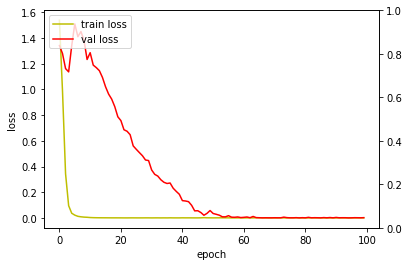

loss: 406968723502.8114
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [   2.1215212 -401.47443    130.51007    -81.59645  ]
(2800, 4)


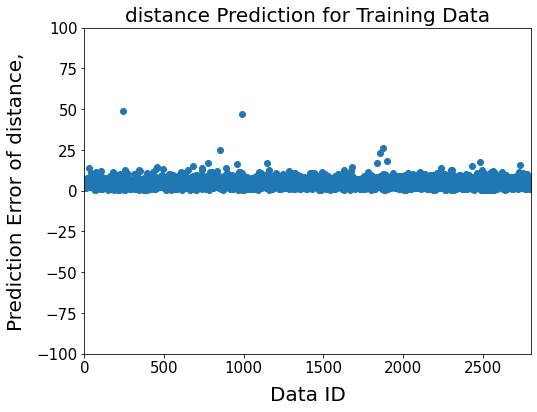

2.8946046325228236
48.7733961509238
0.14037807959416598
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 373, 5, 16)        64        
_________________________________________________________________
batch_normalization_19 (Batc (None, 373, 5, 16)        64        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 186, 5, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 184, 5, 32)        1568      
_________________________________________________________________
batch_normalization_20 (Batc (None, 184, 5, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 92, 5, 32)         0         
________________________________________________________________

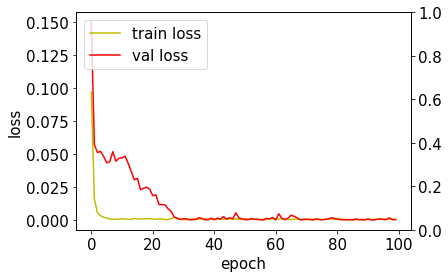

loss: 160698221596320.9
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [ 8.320787  24.943583  47.748127  -1.1829505]
(2800, 4)


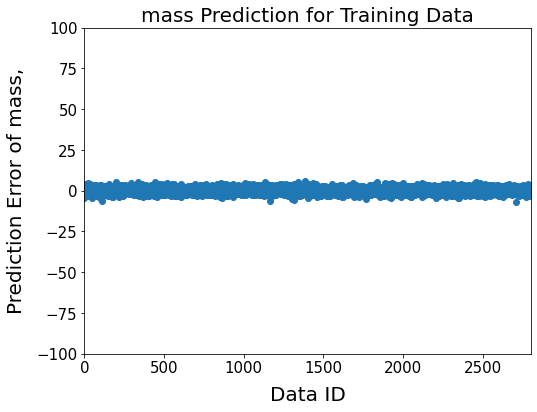

1.937624738607186
5.66796875
-6.666111537388393
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 373, 5, 16)        64        
_________________________________________________________________
batch_normalization_25 (Batc (None, 373, 5, 16)        64        
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 186, 5, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 184, 5, 32)        1568      
_________________________________________________________________
batch_normalization_26 (Batc (None, 184, 5, 32)        128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 92, 5, 32)         0         
_________________________________________________________________
conv2d

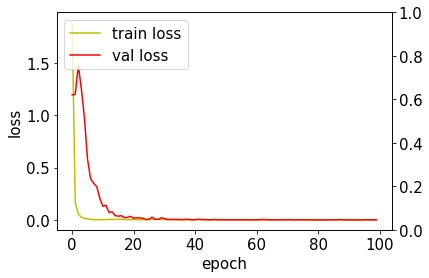

loss: 1126680894411.3372
정답(original): [   0.  -400.    50.     0.4]
예측값(original): [ 1.5077202  -3.5632753   0.84405506  0.42611888]
(2800, 4)


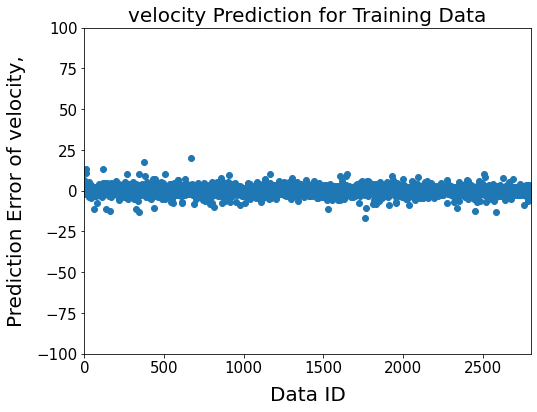

2.5207729536538843
19.784712791442864
-16.438976923624672


In [23]:
submit = pd.read_csv('sample_submission.csv')

for train_target in range(3):
    model = set_model(train_target)
    train(model,X_train, Y_train)    
    best_model = load_best_model(train_target)

   
    pred_data_test = best_model.predict(X_data_test)
    
    
    if train_target == 0: # x,y 학습
        submit.iloc[:,1] = pred_data_test[:,0]
        submit.iloc[:,2] = pred_data_test[:,1]

    elif train_target == 1: # m 학습
        submit.iloc[:,3] = pred_data_test[:,2]

    elif train_target == 2: # v 학습
        submit.iloc[:,4] = pred_data_test[:,3]

In [24]:
submit.to_csv('submit3.csv', index = False)